## Face and Facial Keypoint detection

After you've trained a neural network to detect facial keypoints, you can then apply this network to *any* image that includes faces. The neural network expects a Tensor of a certain size as input and, so, to detect any face, you'll first have to do some pre-processing.

1. Detect all the faces in an image using a face detector (we'll be using a Haar Cascade detector in this notebook).
2. Pre-process those face images so that they are grayscale, and transformed to a Tensor of the input size that your net expects. This step will be similar to the `data_transform` you created and applied in Notebook 2, whose job was to rescale, normalize, and turn any image into a Tensor to be accepted as input to your CNN.
3. Use your trained model to detect facial keypoints on the image.

---

In the next python cell we load in required libraries for this section of the project.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

#### Select an image

Select an image to perform facial keypoint detection on; you can select any image of faces in the `images/` directory. 

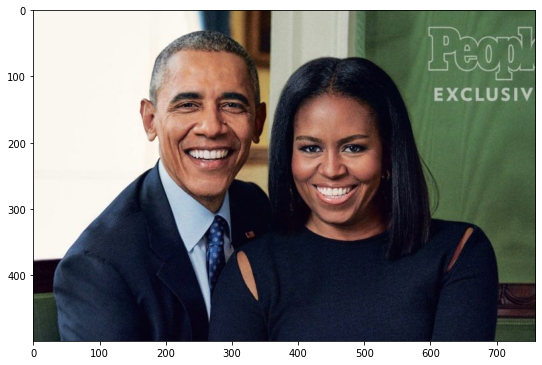

In [ ]:
import cv2
# load in color image for face detection
image = cv2.imread('obamas.jpg')

# switch red and blue color channels
# --> by default OpenCV assumes BLUE comes first, not RED as in many images
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plot the image
fig = plt.figure(figsize=(9,9))
plt.imshow(image)

## Detect all faces in an image

Next, you'll use one of OpenCV's pre-trained Haar Cascade classifiers, all of which can be found in the `detector_architectures/` directory, to find any faces in your selected image.

In the code below, we loop over each face in the original image and draw a red square on each face (in a copy of the original image, so as not to modify the original). You can even [add eye detections](https://docs.opencv.org/3.4.1/d7/d8b/tutorial_py_face_detection.html) as an *optional* exercise in using Haar detectors.

An example of face detections on a variety of images is shown below.

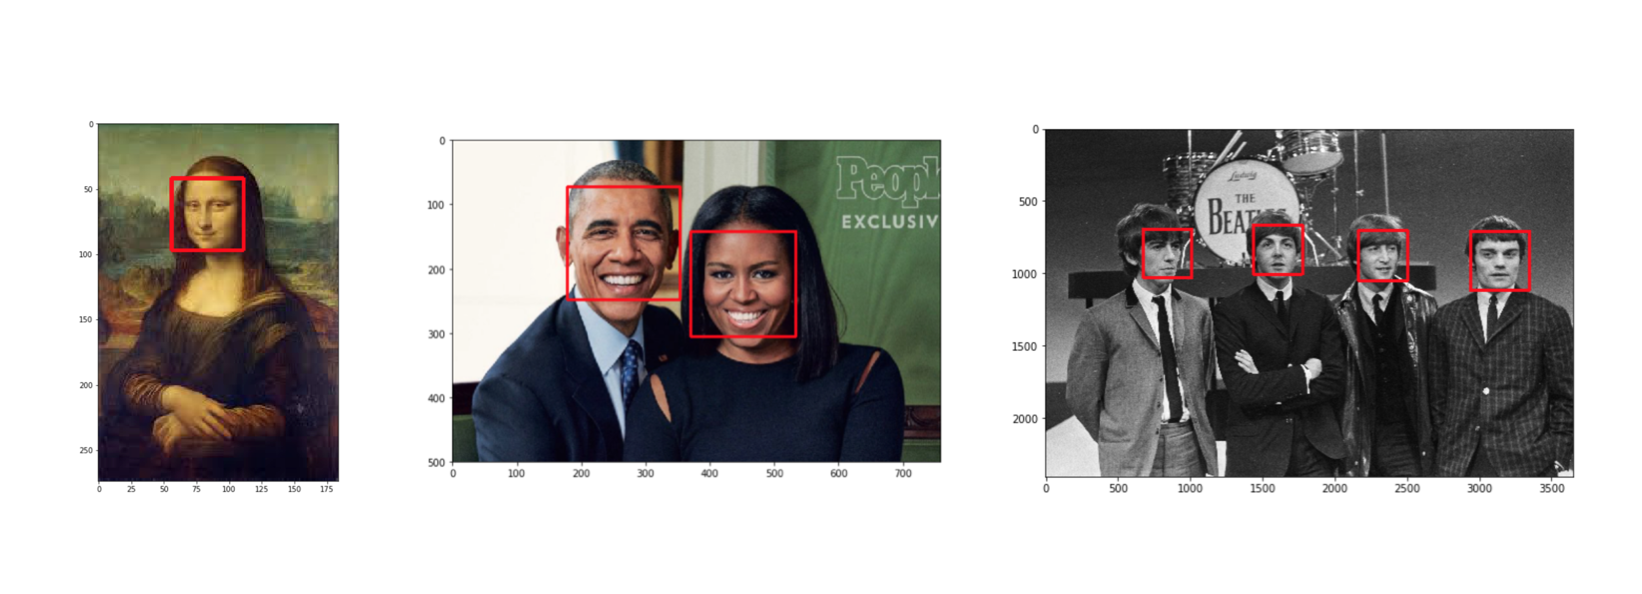

In [ ]:
from IPython.display import Image
Image('haar_cascade_ex.png')

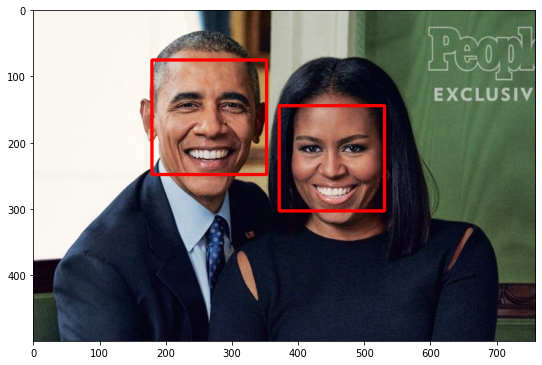

In [ ]:
# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# run the detector
# the output here is an array of detections; the corners of each detection box
# if necessary, modify these parameters until you successfully identify every
# face in a given image
faces = face_cascade.detectMultiScale(image, 1.2, 2)

# make a copy of the original image to plot detections on
image_with_detections = image.copy()

# loop over the detected faces, mark the image where each face is found
for (x,y,w,h) in faces:
  # draw a rectangle around each detected face
  # you may also need to change the width of the rectangle drawn depending on
  # image resolution
  cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3)

fig = plt.figure(figsize=(9,9))

plt.imshow(image_with_detections)

## Loading in a trained model

Once you have an image to work with (and, again, you can select any image of faces in the `images/` directory), the next step is to pre-process that image and feed it into your CNN facial keypoint detector.

First, load your best model by its filename.

In [ ]:
import torch
from models import Net

net = Net()

## TODO: load the best saved model parameters (by your path name)
## You'll need to un-comment the line below and add the correct name for *your*
## saved model
net.load_state_dict(torch.load('keypoints_model_epochs40_bs128_lr001.pt',
                               map_location=torch.device('cpu')))

## print out your net and prepare it for testing (uncomment the line below)
net.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=43264, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=136, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.1, inplace=False)
  (dropout2): Dropout2d(p=0.2, inplace=False)
  (dropout3): Dropout2d(p=0.3, inplace=False)
  (dropout4): Dropout2d(p=0.4, inplace=False)
  (dropout5): Dropout(p=0.5, inplace=False)
  (dropout6): Dropout(p=0.6, inplace=False)
)

## Keypoint detection

Now, we'll loop over each detected face in an image (again!) only this time, you'll transform those faces in Tensors that your CNN can accept as input images.

## TODO: Transform each detected face into an input Tensor

You'll need to perform the following steps for each detected face:
1. Convert the face from RGB to grayscale
2. Normalize the grayscale image so that its color range falls in [0,1] instead of [0, 255]
3. Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
4. Reshape the numpy image into a torch image

**Hint**: The sizes of faces detected by a Haar detector and the faces your network has been trained on are of different sizes. If you find that your model is generating keypoints that are too small for a given face, try adding some padding to the detected `roi` before giving it as input to your model.

You may find it useful to consult the transformation code in `data_load.py` to help you perform these processing steps.

## TODO: Detect and display the predicted keypoints

After each face has been appropriately converted into an input Tensor for your network to see as input, you can apply your `net` to each face. The output should be the predicted facial keypoints. These keypoints will need to be "un-normalized" for display, and you may find it useful to write a helper function like `show_keypoints`. You should end up with an image like the following with facial keypoints that closely match the facial features on each individual face:


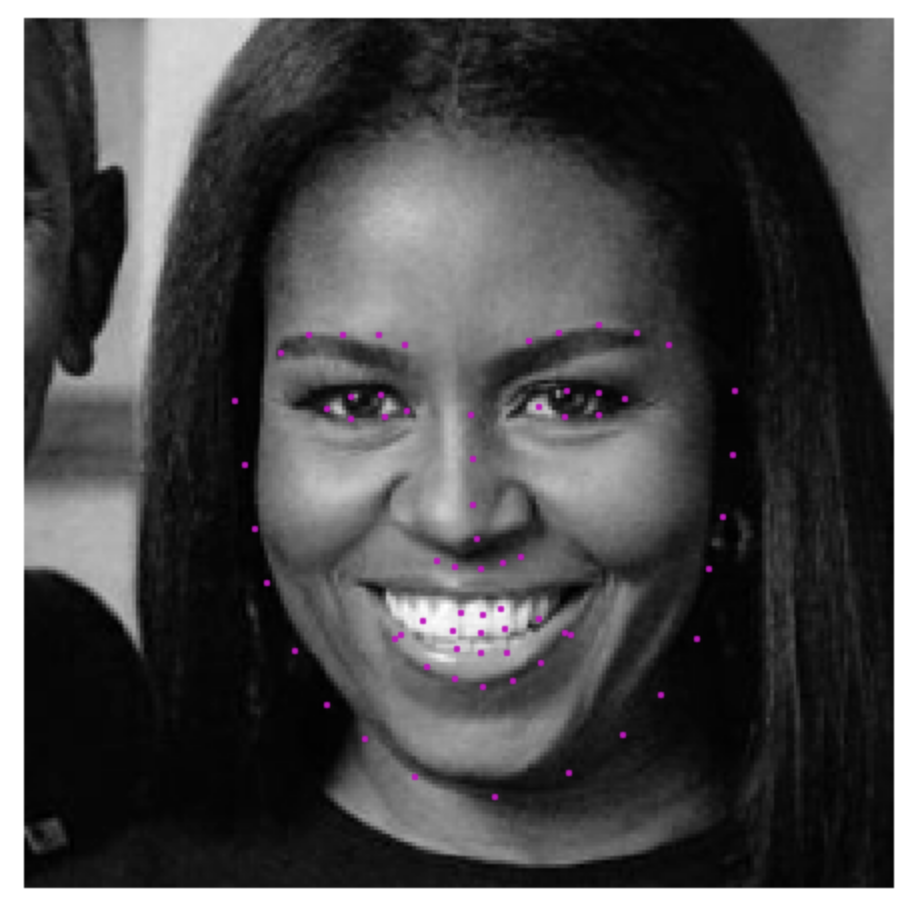

In [ ]:
from IPython.display import Image
Image('michelle_detected.png')

In [ ]:
# test the model on one test image

def predict_keypoints_from_image(image):
  """With PyTorch tensor image as input, returns predicted keypoints"""
  
  image = image.type(torch.FloatTensor)

  # forward pass to get net output for a single image
  output_pts = net(image[None, ...])

  # reshape to batch_size x 68 x 2 pts
  output_pts = output_pts.view(output_pts.size()[0], 68, -1)

  return output_pts

In [ ]:
def show_all_keypoints(image, predicted_key_pts):
  """Show image with predicted keypoints"""

  # image is grayscale
  plt.imshow(image, cmap='gray')
  plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.',
              c='m')

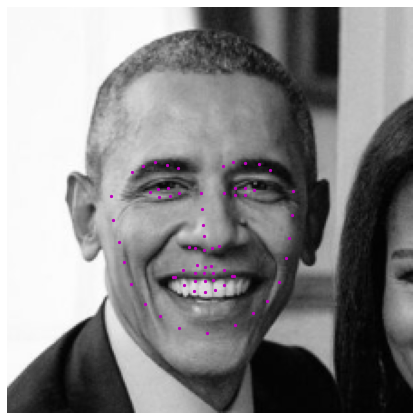

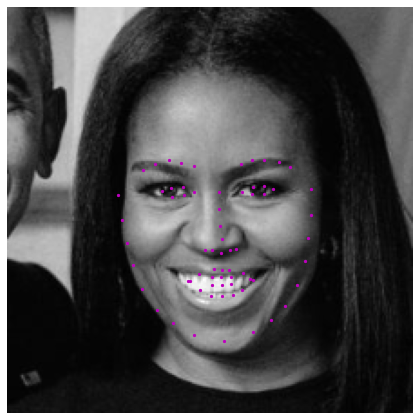

In [ ]:
image_copy = np.copy(image)

# loop over the detected faces from your haar cascade
for i, (x,y,w,h) in enumerate(faces):
  
  plt.figure(figsize=(16,8))
  ax = plt.subplot(1, 2, i+1)

  # Select the region of interest that is the face in the image
  d = 60
  roi = image_copy[y-d:y+h+d, x-d:x+w+d]

  ## TODO: Convert the face region from RGB to grayscale
  roi_gray = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)

  ## TODO: Normalize the grayscale image so that its color range falls in [0,1]
  ## instead of [0,255]
  roi_normalized = roi_gray/255.0

  ## TODO: Rescale the detected face to be the expected square size for your 
  ## CNN (224x224, suggested)
  h, w = roi_normalized.shape[:2]
  if h > w:
    new_h, new_w = 224 * h / w, 224
  else:
    new_h, new_w = 224, 224 * w / h

  new_h, new_w = int(new_h), int(new_w)

  roi_rescaled = cv2.resize(roi_normalized, (new_w, new_h))

  ## TODO: Reshape the numpy image shape (H x W x C) into a torch image shape
  ## (C x H x W)

  # if image has not grayscale color channel, add one
  if(len(roi_rescaled.shape) == 2):
    roi_rescaled = roi_rescaled.reshape(roi_rescaled.shape[0], 
                                      roi_rescaled.shape[1], 1)
    
  # swap color axis because
  # numpy image: H x W x C
  # torch image: C x H x W
  roi_reshaped = roi_rescaled.transpose((2, 0, 1))

  # Turn numpy image into PyTorch tensor
  roi_tensor = torch.from_numpy(roi_reshaped)

  ## TODO: Make facial keypoint prediction using your loaded, trained network
  predicted_key_pts = predict_keypoints_from_image(roi_tensor)

  ## TODO: Display each detected face and the corresponding keypoints
  image_for_plot = roi_tensor[0].data.numpy()
  image_for_plot = np.squeeze(image_for_plot)

  show_all_keypoints(image_for_plot, 
                   predicted_key_pts[0].data.numpy()*50.0 + 100)
  
  plt.axis('off')

plt.show()